In [5]:
from random import random
import matplotlib.pyplot as plt
n = 8
heights = [[random() for i in range(n)] for j in range(n)]
# heights = [[i * j for i in range(n)] for j in range(n)]

In [6]:
import numpy as np

# Interpolates a square heightmap using bicubic interpolation
# Methods:
#  - height(x, y) -> float            : returns the interpolated height at (x, y)
#  - gradient(x, y) -> [float, float] : returns the gradient of the interpolated height at (x, y)
# Height has continuous first derivatives; gradient is merely continuous
class HeightmapInterpolator:
    # From wikipedia: https://en.wikipedia.org/wiki/Bicubic_interpolation#Computation
    # The matrix product m * x * m^T where x =
    #     f(0, 0),  f(0, 1),  fy(0, 0),  fy(0, 1)
    #     f(0, 0),  f(0, 1),  fy(0, 0),  fy(0, 1)
    #     fx(0, 0), fx(0, 1), fxy(0, 0), fxy(0, 1)
    #     fx(0, 0), fx(0, 1), fxy(0, 0), fxy(0, 1)
    # gives the matrix of coefficients a which can be used to calculate p(x, y) by the following formula:
    # p(x, y) = [1 x x^2 x^3] * a * [a y y^2 y^3]^T
    _m = np.array([
        [ 1, 0, 0, 0],
        [ 0, 0, 1, 0],
        [-3, 3,-2,-1],
        [ 2,-2, 1, 1]
    ])

    @staticmethod
    def _calc_interpolation_matrix(heightmap, x, y):
        def f(x, y): return heightmap[x][y]
        def fx(x, y): return 0.5 * (f(x + 1, y) - f(x - 1, y))
        def fy(x, y): return 0.5 * (f(x, y + 1) - f(x, y - 1))
        def fxy(x, y): return 0.25 * (f(x + 1, y + 1) + f(x - 1, y - 1) - f(x - 1, y + 1) - f(x + 1, y - 1))

        f00,   f01,   f10,   f11   = f(x, y),   f(x, y + 1),   f(x + 1, y),   f(x + 1, y + 1)
        f00x,  f01x,  f10x,  f11x  = fx(x, y),  fx(x, y + 1),  fx(x + 1, y),  fx(x + 1, y + 1)
        f00y,  f01y,  f10y,  f11y  = fy(x, y),  fy(x, y + 1),  fy(x + 1, y),  fy(x + 1, y + 1)
        f00xy, f01xy, f10xy, f11xy = fxy(x, y), fxy(x, y + 1), fxy(x + 1, y), fxy(x + 1, y + 1)

        M = np.array([
            [f00,  f01,  f00y,  f01y],
            [f10,  f11,  f10y,  f11y],
            [f00x, f01x, f00xy, f01xy],
            [f10x, f11x, f10xy, f11xy]
        ])
        return np.linalg.multi_dot((HeightmapInterpolator._m, M, HeightmapInterpolator._m.transpose()))

    def __init__(self, N, heightmap):
        # Extend the heightmap
        self.heightmap = heightmap
        self.N = N

        # 2d array of 4x4 matrices
        self._height_interpolation = [[HeightmapInterpolator._calc_interpolation_matrix(heightmap, X, Y) for X in range(1, N - 2)] for Y in range(1, N - 2)]

    # Get cached result, or calculate it and cache it
    def _interpolation_matrix(self, X, Y):
        return self._height_interpolation[Y][X]

    def get_height(self, x, y):
        x -= 1
        y -= 1
        # Assume the height outside the heightmap is infinity
        if x < 0 or x >= self.N - 3 or y < 0 or y >= self.N - 3:
            return float('inf')

        # X, Y = index of heightmap; t_x, t_y = proportion of the way to the next value
        X, tx = int(x), x % 1
        Y, ty = int(y), y % 1

        vx = np.array([1, tx, tx ** 2, tx ** 3])
        vy = np.array([1, ty, ty ** 2, ty ** 3])
        M = self._interpolation_matrix(X, Y)

        return np.linalg.multi_dot((vx, M, vy))

    def get_gradient(self, x, y):
        x -= 1
        y -= 1
        # Assume the height outside the heightmap is infinity
        if x < 0 or x >= self.N - 3 or y < 0 or y >= self.N - 3:
            return [1, 1, 1]

        # X, Y = index of heightmap; t_x, t_y = proportion of the way to the next value
        X, tx = int(x), x % 1
        Y, ty = int(y), y % 1

        vx = np.array([1, tx, tx ** 2, tx ** 3])
        vy = np.array([1, ty, ty ** 2, ty ** 3])
        vx_ = np.array([0, 1, 2 * tx, 3 * tx ** 2])
        vy_ = np.array([0, 1, 2 * ty, 3 * ty ** 2])
        M = self._interpolation_matrix(X, Y)

        return [np.linalg.multi_dot((vx_, M, vy)) / 2 + 0.5, np.linalg.multi_dot((vx, M, vy_)) / 2 + 0.5, 0]

In [9]:
hMap = HeightmapInterpolator(n, heights)

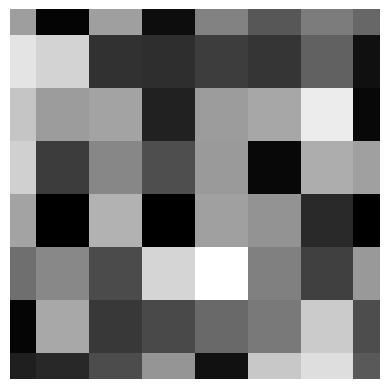

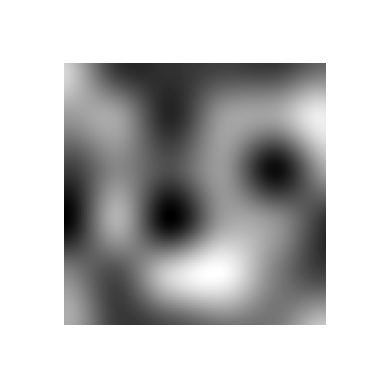

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


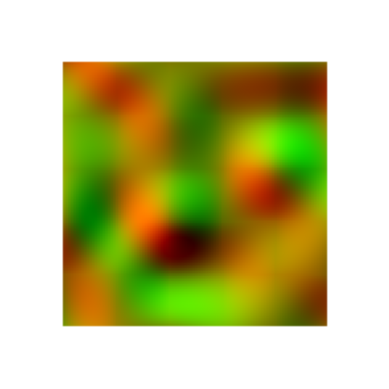

In [10]:
hPoints = [
    [heights[int(i + 0.5)][int(j + 0.5)] for i in np.arange(0, n - 1, .5)] for j in np.arange(0, n - 1, .5)
]
plt.imshow(hPoints, cmap='binary')
plt.axis('off')
plt.show()

hPoints = [
    [hMap.get_height(i, j) for i in np.arange(0, n - 1, 0.05)] for j in np.arange(0, n - 1, 0.05)
]
plt.imshow(hPoints, cmap='binary')
plt.axis('off')
plt.show()

gPoints = [
    [hMap.get_gradient(i, j) for i in np.arange(0, n - 1., 0.05)] for j in np.arange(0, n - 1, 0.05)
]
plt.imshow(gPoints, cmap='binary')
plt.axis('off')
plt.show()

E:\Programs\python\Lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


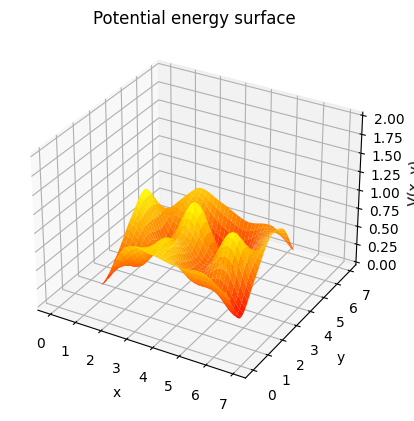

In [11]:
import matplotlib.pyplot as plt
import numpy as np


ax = plt.figure().add_subplot(projection='3d')

X, Y = np.mgrid[0 : n - 1 : 0.05, 0 : n - 1 : 0.05]
Z = np.array([[hMap.get_height(x, y) for x, y in zip(x_, y_)] for x_, y_ in zip(X, Y)])

ax.plot_surface(X, Y, Z, cmap='autumn')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("V(x, y)")
ax.set_zlim(0, 2)

plt.title('Potential energy surface')

plt.show()

In [12]:
# Benchmark
# On my computer, we can call get_gradient 100,000 times in about 4 seconds. Should be mostly fast enough?
import timeit
start_time = timeit.default_timer()
for i in range(100000):
    hMap.get_gradient(1, 1 + 1 / (1 + i))
print(timeit.default_timer() - start_time)

4.151741700000457
